# Where can young voters swing the EU election?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import plotly
import plotly.express as px
import plotly.graph_objects as go
plt.rcParams['figure.figsize']=17,8
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

import folium
pyo.init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
df = pd.read_csv('data/Eurostat-PopulationProjection2019-proj_15npms.csv')
df.head()

,TIME,GEO,UNIT,AGE,SEX,PROJECTION,Value,Flag and Footnotes
0,2019,European Union - 28 countries,Person,Total,Total,Baseline projections,"514,436,397",NaN
1,2019,European Union - 28 countries,Person,16 years,Total,Baseline projections,"5,235,779",NaN
2,2019,European Union - 28 countries,Person,17 years,Total,Baseline projections,"5,299,432",NaN
3,2019,European Union - 28 countries,Person,18 years,Total,Baseline projections,"5,466,860",NaN
4,2019,European Union - 28 countries,Person,19 years,Total,Baseline projections,"5,465,394",NaN


In [3]:
population = df [['GEO','AGE','Value']]
population=population[population['AGE']!='Total']      #remove total

population.head(100)

,GEO,AGE,Value
1,European Union - 28 countries,16 years,"5,235,779"
2,European Union - 28 countries,17 years,"5,299,432"
3,European Union - 28 countries,18 years,"5,466,860"
4,European Union - 28 countries,19 years,"5,465,394"
5,European Union - 28 countries,20 years,"5,551,222"
...,...,...,...
97,Belgium,26 years,"150,466"
98,Belgium,27 years,"153,268"
99,Belgium,28 years,"153,383"
100,Belgium,29 years,"151,211"


In [4]:
#remove year from age

asd=population['AGE'].str.split(' ',n = 0, expand = True)   #remove year 
age=asd[0]
population['age']=age
population['age']=population['age'].astype(int)            #convert age to int
del population['AGE']

In [5]:
#remove , from value
def float_conversion(value_str):
    value = float(value_str.replace(',',''))
    return value
population['Value'] = population['Value'].apply(float_conversion)

In [6]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2465 entries, 1 to 2493
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GEO     2465 non-null   object 
 1   Value   2465 non-null   float64
 2   age     2465 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 67.4+ KB


In [7]:
population=population[['GEO','age','Value']]                         #change cloumn position
population.columns=(['location','age','number_people'])             #change cloumn names
population.head()

,location,age,number_people
1,European Union - 28 countries,16,5235779.0
2,European Union - 28 countries,17,5299432.0
3,European Union - 28 countries,18,5466860.0
4,European Union - 28 countries,19,5465394.0
5,European Union - 28 countries,20,5551222.0


In [8]:
# Greece: 17                        remove 16
# Austria and Malta: 16             dont remove
# All others: 18                    remove 16 17


remove16_17=population[((population.location != 'Austria')&(population.location != 'Malta') &( population.age == 16)|(population.location != 'Austria')&(population.location != 'Malta')&(population.location != 'Greece') &( population.age == 17))].index
final_data=population.drop(remove16_17)
final_data.to_csv('final_data.csv')
final_data

,location,age,number_people
3,European Union - 28 countries,18,5466860.0
4,European Union - 28 countries,19,5465394.0
5,European Union - 28 countries,20,5551222.0
6,European Union - 28 countries,21,5656744.0
7,European Union - 28 countries,22,5740663.0
...,...,...,...
2489,United Kingdom,96,34324.0
2490,United Kingdom,97,25398.0
2491,United Kingdom,98,16642.0
2492,United Kingdom,99,9125.0


In [9]:
final_data.groupby('location')['number_people'].sum()

location
Austria                            7566196.0
Belgium                            9173132.0
Bulgaria                           5817244.0
Croatia                            3390190.0
Cyprus                              702707.0
Czechia                            8658033.0
Denmark                            4678256.0
Estonia                            1064265.0
European Union - 28 countries    418953478.0
Finland                            4467177.0
France                            52732008.0
Germany                           70102621.0
Greece                             8909593.0
Hungary                            8079687.0
Ireland                            3554162.0
Italy                             50974954.0
Latvia                             1564165.0
Lithuania                          2284315.0
Luxembourg                          496440.0
Malta                               379393.0
Netherlands                       13929735.0
Poland                            31131793.0
P

In [10]:
countries_list=[]
for country in final_data['location'] :
    countries_list.append(country)
countries = set(countries_list)
countries

{'Austria',
 'Belgium',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'European Union - 28 countries',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'United Kingdom'}

In [11]:
voter_structures = []

for country in countries:
    country_dict = {}
    if country == 'Austria':
        country_dict['location'] = country
        voters = final_data[final_data['location']==country]['number_people'].sum()
        country_dict['eligible_voters'] = voters
        # first time voters are at least 16, but maximum 20 years old
        first_timers = final_data[(final_data['location']==country)&((final_data['age']<=20))]['number_people'].sum()
        country_dict['firsttime_voters'] = first_timers
        country_dict['share_firsttimers %'] = int(first_timers/voters*100)
        # voters <= to age 30        
        age30_voters = final_data[(final_data['location']==country)&((final_data['age']<=30))]['number_people'].sum()
        country_dict['age30_voters'] = age30_voters
        country_dict['share_age30_voters %'] = int(age30_voters/voters*100)
         # voters > to age 30        
        age_more_30_voters = final_data[(final_data['location']==country)&((final_data['age']>30))]['number_people'].sum()
        country_dict['age_more_30_voters'] = age_more_30_voters
        country_dict['share_age_more_30_voters %'] = int(age_more_30_voters/voters*100)
        voter_structures.append(country_dict)
       
    elif country == 'Malta':
        country_dict['location'] = country
        voters = final_data[final_data['location']==country]['number_people'].sum()
        country_dict['eligible_voters'] = voters
        # first time voters are at least 16, but maximum 22 years old
        first_timers = final_data[(final_data['location']==country)&((final_data['age']<=22))]['number_people'].sum()
        country_dict['firsttime_voters'] = first_timers
        country_dict['share_firsttimers %'] = int(first_timers/voters*100)
        # voters <= to age 30        
        age30_voters = final_data[(final_data['location']==country)&((final_data['age']<=30))]['number_people'].sum()
        country_dict['age30_voters'] = age30_voters
        country_dict['share_age30_voters %'] = int(age30_voters/voters*100)
         # voters > to age 30        
        age_more_30_voters = final_data[(final_data['location']==country)&((final_data['age']>30))]['number_people'].sum()
        country_dict['age_more_30_voters'] = age_more_30_voters
        country_dict['share_age_more_30_voters %'] = int(age_more_30_voters/voters*100)  
        voter_structures.append(country_dict)
     
    elif country == 'Greece':
        country_dict['location'] = country
        voters = final_data[final_data['location']==country]['number_people'].sum()
        country_dict['eligible_voters'] = voters
        # first time voters are at least 17, but maximum 22 years old
        first_timers = final_data[(final_data['location']==country)&((final_data['age']<=22))]['number_people'].sum()
        country_dict['firsttime_voters'] = first_timers
        country_dict['share_firsttimers %'] = int(first_timers/voters*100)
        # voters <= to age 30        
        age30_voters = final_data[(final_data['location']==country)&((final_data['age']<=30))]['number_people'].sum()
        country_dict['age30_voters'] = age30_voters
        country_dict['share_age30_voters %'] = int(age30_voters/voters*100)
         # voters > to age 30        
        age_more_30_voters = final_data[(final_data['location']==country)&((final_data['age']>30))]['number_people'].sum()
        country_dict['age_more_30_voters'] = age_more_30_voters
        country_dict['share_age_more_30_voters %'] = int(age_more_30_voters/voters*100)  
        voter_structures.append(country_dict)

    else:
        country_dict['location'] = country
        voters = final_data[final_data['location']==country]['number_people'].sum()
        country_dict['eligible_voters'] = voters
        # first time voters are at least 18, but maximum 22 years old
        first_timers = final_data[(final_data['location']==country)&((final_data['age']<=22))]['number_people'].sum()
        country_dict['firsttime_voters'] = first_timers
        country_dict['share_firsttimers %'] = int(first_timers/voters*100)
        # voters <= to age 30        
        age30_voters = final_data[(final_data['location']==country)&((final_data['age']<=30))]['number_people'].sum()
        country_dict['age30_voters'] = age30_voters
        country_dict['share_age30_voters %'] = int(age30_voters/voters*100)
         # voters > to age 30        
        age_more_30_voters = final_data[(final_data['location']==country)&((final_data['age']>30))]['number_people'].sum()
        country_dict['age_more_30_voters'] = age_more_30_voters
        country_dict['share_age_more_30_voters %'] = int(age_more_30_voters/voters*100)     
        voter_structures.append(country_dict)

In [12]:
voters_df = pd.DataFrame(voter_structures)
voters_df.sort_values(by='share_firsttimers %', ascending = False)

,location,eligible_voters,firsttime_voters,share_firsttimers %,age30_voters,share_age30_voters %,age_more_30_voters,share_age_more_30_voters %
10,Malta,379393.0,33492.0,8,85563.0,22,293830.0,77
0,Luxembourg,496440.0,36071.0,7,105379.0,21,391061.0,78
20,Cyprus,702707.0,51270.0,7,161797.0,23,540910.0,76
17,France,52732008.0,4153587.0,7,10419653.0,19,42312355.0,80
16,Ireland,3554162.0,265273.0,7,671663.0,18,2882499.0,81
15,Greece,8909593.0,645219.0,7,1539904.0,17,7369689.0,82
13,United Kingdom,52837136.0,4074362.0,7,11428969.0,21,41408167.0,78
14,Denmark,4678256.0,363114.0,7,1006442.0,21,3671814.0,78
3,Netherlands,13929735.0,1067517.0,7,2858572.0,20,11071163.0,79
6,Belgium,9173132.0,654515.0,7,1832324.0,19,7340808.0,80


In [13]:
px.bar(voters_df,x='location',y=['share_firsttimers %','share_age30_voters %'])

In [14]:
voters_df.iplot(kind='bar',x='location',y=['share_firsttimers %','share_age30_voters %'])

# Voter turnout among total voting age population for European elections

Voter turnout: IDEA database

URL: https://www.idea.int/data-tools/continent-view/Europe/40?st=eup#rep

In [15]:
voter_turnout2019 = pd.read_csv('data/idea_export_40_60718b91ebceb.csv')
voter_turnout2019

,Country,Election type,Year,Voter Turnout,Total vote,Registration,VAP Turnout,Voting age population,Population,Invalid votes,Compulsory voting
0,Austria,EU Parliament,2019,59.77 %,"3,834,662","6,416,177",51.07 %,"7,508,169","8,828,456",1.43 %,No
1,Austria,EU Parliament,2014,45.39 %,"2,909,497","6,410,602",39.77 %,"7,315,273","8,615,828",3.00 %,No
2,Austria,EU Parliament,2009,45.97 %,"2,925,132","6,362,761",41.32 %,"7,078,928","8,428,464",2.07 %,No
3,Austria,EU Parliament,2004,42.43 %,"2,566,639","6,049,129",39.95 %,"6,424,824","8,140,122",2.60 %,No
4,Austria,EU Parliament,1999,49.01 %,"2,865,977","5,847,605",46.11 %,"6,215,766","7,982,461",NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
170,United Kingdom,EU Parliament,1999,24.02 %,"10,689,847","44,495,741",24.08 %,"44,397,675","58,579,685",NaN,No
171,United Kingdom,EU Parliament,1994,36.43 %,"15,827,417","43,443,944",36.13 %,"43,803,344","57,788,017",NaN,No
172,United Kingdom,EU Parliament,1989,36.21 %,"15,829,054","43,710,568",36.87 %,"42,928,786","56,996,450",0.00 %,No
173,United Kingdom,EU Parliament,1984,32.57 %,"13,998,190","42,984,998",33.69 %,"41,555,327","56,362,502",0.00 %,No


In [16]:
turnout2019 = voter_turnout2019[['Country','Year','Voter Turnout', 'Voting age population']]       #choose column
turnout2019.columns = (['country', 'year','voter_turnout%','voting_age_population'])    #change column name
turnout2019.head(30)

,country,year,voter_turnout%,voting_age_population
0,Austria,2019,59.77 %,"7,508,169"
1,Austria,2014,45.39 %,"7,315,273"
2,Austria,2009,45.97 %,"7,078,928"
3,Austria,2004,42.43 %,"6,424,824"
4,Austria,1999,49.01 %,"6,215,766"
5,Austria,1996,67.73 %,"6,172,678"
6,Belgium,2019,88.47 %,"9,261,362"
7,Belgium,2014,89.64 %,"8,206,928"
8,Belgium,2009,90.39 %,"8,356,666"
9,Belgium,2004,90.81 %,"8,110,168"


In [17]:
#delete % and convert voter_turnout to float
def value_conversion(value_str):
    value=float(value_str.replace(" %",""))
    return value
turnout2019['voter_turnout%'] = turnout2019['voter_turnout%'].apply(value_conversion)
turnout2019

,country,year,voter_turnout%,voting_age_population
0,Austria,2019,59.77,"7,508,169"
1,Austria,2014,45.39,"7,315,273"
2,Austria,2009,45.97,"7,078,928"
3,Austria,2004,42.43,"6,424,824"
4,Austria,1999,49.01,"6,215,766"
...,...,...,...,...
170,United Kingdom,1999,24.02,"44,397,675"
171,United Kingdom,1994,36.43,"43,803,344"
172,United Kingdom,1989,36.21,"42,928,786"
173,United Kingdom,1984,32.57,"41,555,327"


In [18]:
turnout2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                175 non-null    object 
 1   year                   175 non-null    int64  
 2   voter_turnout%         175 non-null    float64
 3   voting_age_population  169 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.6+ KB


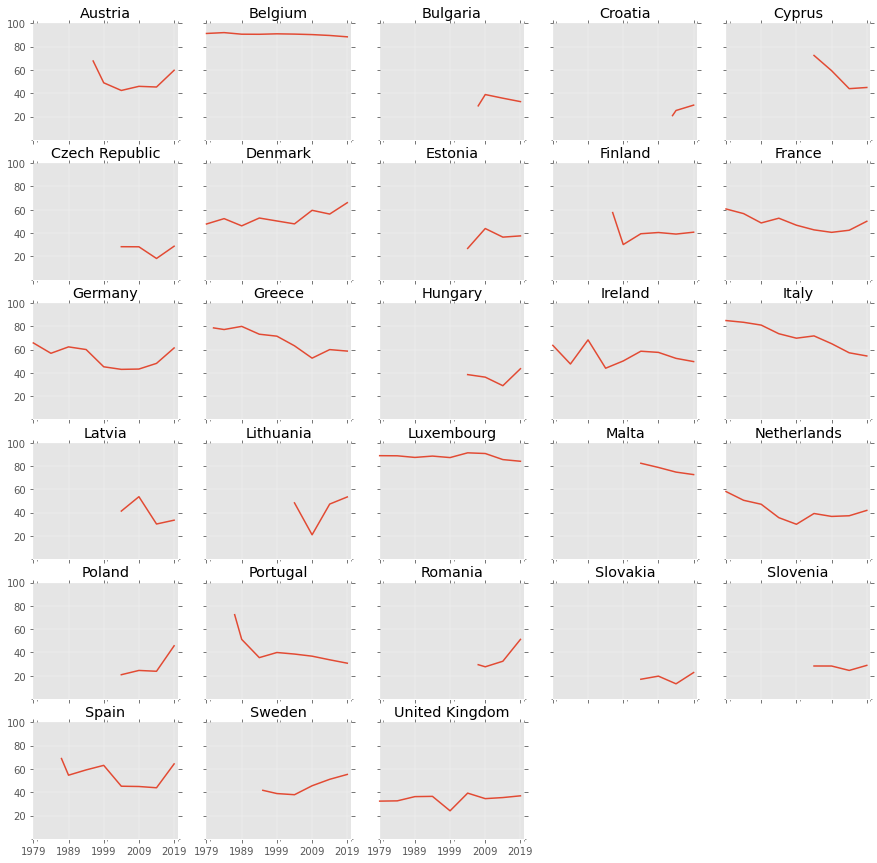

In [19]:
fig, axes = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=True, figsize=(15,15))
axes_list = [item for sublist in axes for item in sublist] 

for countryname, selection in turnout2019.groupby("country"):
    ax = axes_list.pop(0)
    selection.plot(x='year', y='voter_turnout%', label=countryname, ax=ax, legend=False, clip_on=False)
    ax.set_title(countryname)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off',
    )
    ax.grid(linewidth=0.25)
    ax.set_xlim((1979, 2020))
    ax.set_ylim((0,100))
    ax.set_xlabel("")
    ax.set_xticks(range(1979, 2020, 10))
    ax.set_yticks(range(20, 120, 20))
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axes_list:
    ax.remove()

plt.savefig('Voter-Turnout-EU-Elections.png', transparent = True)

In [20]:
turnout2019[turnout2019['year']==2019].median()

year              2019.000
voter_turnout%      47.685
dtype: float64

In [21]:
only2019=turnout2019[turnout2019['year']==2019].sort_values(by='voter_turnout%', ascending = False)
only2019

,country,year,voter_turnout%,voting_age_population
6,Belgium,2019,88.47,"9,261,362"
106,Luxembourg,2019,84.10,"493,482"
115,Malta,2019,72.66,"375,902"
30,Denmark,2019,66.08,"4,673,427"
152,Spain,2019,64.30,"40,650,233"
58,Germany,2019,61.38,"67,810,122"
0,Austria,2019,59.77,"7,508,169"
67,Greece,2019,58.69,"9,082,362"
160,Sweden,2019,55.27,"8,009,142"
89,Italy,2019,54.50,"52,146,748"


In [22]:
px.bar(only2019,x='country',y='voter_turnout%',title='Voter-Turnout-EU-Elections2019 percentage')

In [23]:
only2019.iplot(kind='bar',x='country',y='voter_turnout%',title='Voter-Turnout-EU-Elections2019 percentage')